# GPflow Tutorial

Here I will walk through how to install, set up and import, and use GPflow to do some simple gaussian process modeling. [GPflow](http://gpflow.readthedocs.io/en/latest/intro.html) is a Python package using TensorFlow. More information can be found at their website.

As some of the documentation for GPflow is not as explicit as may be useful for direct implementation depending on one's goals, the purpose of this notebook is provide clarity on the most common features of the package that one may want to use when doing Gaussian process modeling.

This notebook was last updated by Daniel Gilford on Jan. 4, 2019. <br>(Please email questions to daniel.gilford@rutgers.edu)

# Installing Amarel

Although installation can and will vary from system to system, and depending on your Python setup, we walk through the simplest way to install GPflow on Amarel here.

First, briefly review the [Installation Guide](http://gpflow.readthedocs.io/en/latest/intro.html#install) in the GPflow documentation. Clone the GPflow repository with the command:

```git clone https://github.com/GPflow/GPflow```

Then navigate to the main /GPflow/ directory, and in your appropriate build of Python, from the command line use:

```pip install --user .```

You should receive a message letting you know that it has been sucessfully installed.

# Simple 1D examples of GPflow

Here we will walkthrough a simple example of using GPflow to fit a function defined only by a single dimension/parameter. Our objectives are:
1. Import GPflow (and associated packages for the example)
2. Create/Visualize practice dataset
3. Build the GPflow model object
4. Optimize the model
5. Visualize the model and samples from it

### Import Packages

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import random

### Create Example Dataset

We choose a simple example dataset from a trigonometric function which is out target. The random variable is fixed with every iteration of this notebook for fidelity:

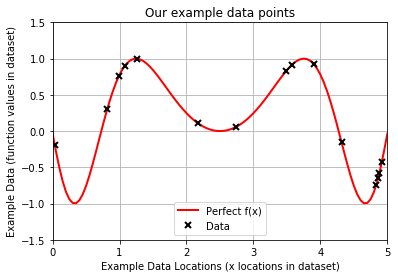

In [2]:
# fix the random state for our noise
rng = np.random.RandomState(4)
# define the x-axis locations of our example data and the query grid to plot the f(x)
xx = np.linspace(0, 5.0, 101).reshape(101, 1)
X = rng.uniform(0, 5.0, 15)[:, np.newaxis]
# observed function output
Y = np.sin((X[:, 0] - 2.5) ** 2).reshape(len(X),1)
# plot
plt.figure()
plt.plot(xx,np.sin((xx[:, 0] - 2.5) ** 2).reshape(len(xx),1),'r',lw=2,label='Perfect f(x)')
plt.plot(X, Y, 'kx', mew=2,label='Data')
plt.title('Our example data points')
plt.xlabel('Example Data Locations (x locations in dataset)')
plt.ylabel('Example Data (function values in dataset)')
plt.legend(loc='best')
plt.ylim([-1.5,1.5])
plt.xlim([0,5])
plt.grid()
plt.show()

It is important to note for later in this example that the example data we are using here is perfect (no noise has been added).

### Build the GPflow Model

With our training example data in hand, we can build the model object with GPflow to do our Gaussian Process Modeling. GPflow creates an object ("m") which initially is defined with some covariance function ("kernel") defined by the user. The model always has an initial set of default properties (including for instance, a fixed white noise term sometimes known as the nugget) which can be manipulated by the user before or after optimization.

We begin by defining a simple Squared-exponential covariance function which will be our input kernel:

In [3]:
k=gpflow.kernels.RBF(1)

Now create the model:

In [4]:
with gpflow.defer_build():
    m = gpflow.models.GPR(X, Y, kern=k)

Where "kern" is a keyword set to bring in the covariance function we defined. We could also use a more complicated kernel, which we will explore below.

Now, what does this object look like? We can query with the nice pandas feature implemented in GPflow:

In [5]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


This table shows a complete rundown of the current model before it has been compiled (built, note from above with defered the build of the model until later in this code) or optimized.

We will discuss more of the features of this table below when we start manipulating the priors/nugget etc., but just note here:<br>
a) "likelihood/variance" refers the white noise nugget which is always included in the GPM by default.<br>
b) the covariance function (RBF) we defined lives in m.kern and has a lengthscale and variance (amplitude/scale) assoociated with it.<br>
c) the value of the noise, amplitude/scale, and length scales can all be found in the far right column.<br>
d) whether a parameter is "trainable" or not will determine whether that parameter can be optimized. The default is that all parameters are optimizable, including the nugget.<br>
e) the shape/dimensionality of the kernel is not defined yet, so the lengthscale of the kernel will apply to all directions/dimensions (currently just 1 in our example).<br>

### Optimize the Model

The model may be optimized quite simply with the appropriate method of thje model object. The optimization in GPflow has been done with Scipy under the hood, but note that not every feature of the Scipy optimization has been rolled over into it's GPflow implementation.

In [6]:
# first, compile/build the model
m.compile()

# then optimize, where the target is the maximum log likelihood
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -6.436910
  Number of iterations: 28
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -6.436910
  Number of iterations: 28
  Number of functions evaluations: 37


The warning that is included above appears every time gpflow is run, a common problem with the package. <br>
The log likelihood of the model fit is reported under "Objective function value". With our model built and optimized, we can begin to query it.

### Visualize and Sample

In [7]:
# look at optimized parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.4568843131519113
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.7373908454211421
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0000011017853296e-06


The parameters have changed from their prior default values to their optimized values. Because "trainable" was left as true for all parameters, the model was optimized to allow them all to vary.

Note that the noise term is very close to zero, which matches out intuition as there was no noise in the example training data.

We can visualize the results of the model now. We first define a query grid where at each point in the grid we will evaluate the model mean and standard deviation:

In [8]:
# query the model
mean, var = m.predict_y(xx)

Where we have stored the mean and standard deviation of the model. We can now plot the plot the result:

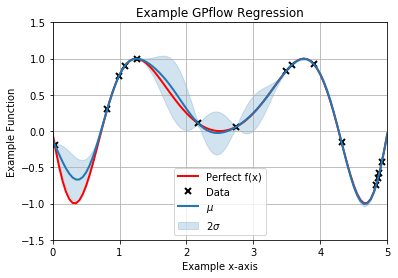

In [9]:
# plot
plt.plot(xx,np.sin((xx[:, 0] - 2.5) ** 2).reshape(len(xx),1),'r',lw=2,label='Perfect f(x)')
plt.plot(X, Y, 'kx', mew=2,label='Data')
line, = plt.plot(xx, mean, lw=2,label='$\mu$')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2,label='$2\sigma$')
plt.legend(loc='lower center')
plt.title('Example GPflow Regression')
plt.xlabel('Example x-axis')
plt.ylabel('Example Function')
plt.ylim([-1.5,1.5])
plt.xlim([0,5])
plt.grid()
plt.show()

We see that the model performs very well reproducing the target (true) function in most regions. This in retrospect is not too suprising, because there was no noise in our training data (it was a perfect representation of the model at the points where it was defined). In reality, most observations will have noise and the model will need flexibility to account for it. Note also that in the regions where we have no training data, the true function value can deviate dramatically from the GP mean because the function is unconstrained there and reverts towards the prior function value.

## Including Noise

We now include noise in our training datset to see how the model can deviate when noise is included. We will conclude this example by drawing samples from our GP which can be used for a variety of applications, including a distribution of the model's uncertainty.

### Create Noisy Dataset

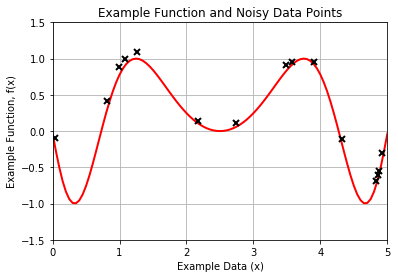

In [10]:
# fix the random state
rng = np.random.RandomState(4)
# define the x-axis locations of our example data
X = rng.uniform(0, 5.0, 15)[:, np.newaxis]
#create our noise variable
noise_scale=0.15
noise_added=noise_scale*np.random.uniform(0,1,len(X)).reshape(len(X),1)
# observed function output
Y = np.sin((X[:, 0] - 2.5) ** 2).reshape(len(X),1)+noise_added
# plot
fig1=plt.figure()
plt.plot(xx,np.sin((xx[:, 0] - 2.5) ** 2).reshape(len(xx),1),'r',lw=2,label='Perfect f(x)')
plt.plot(X, Y, 'kx', mew=2,label='Data')
plt.title('Example Function and Noisy Data Points')
plt.ylabel('Example Function, f(x)')
plt.xlabel('Example Data (x)')
#plt.legend(loc='best')
plt.ylim([-1.5,1.5])
plt.xlim([0,5])
plt.grid()
plt.show()

### Create GP Model and Optimize

Now we have a new training dataset with noise added.

In [11]:
# define the covariance function
k=gpflow.kernels.RBF(1)

# define the model
with gpflow.defer_build():
    m = gpflow.models.GPR(X, Y, kern=k)
    
# build the model
m.compile()

# optimize
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 3.047267
  Number of iterations: 11
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 3.047267
  Number of iterations: 11
  Number of functions evaluations: 16


In [12]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.3532106316012399
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.4432822862856557
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.002481627521097767


In [13]:
# define a query grid and query the model
xx = np.linspace(0, 5.0, 101).reshape(101, 1)
mean, var = m.predict_y(xx)

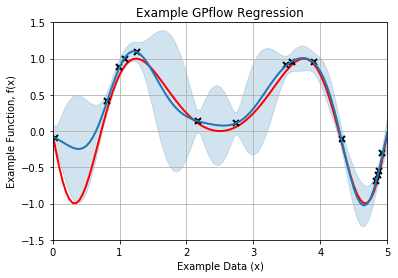

In [14]:
# plot
fig2=plt.figure()
plt.plot(xx,np.sin((xx[:, 0] - 2.5) ** 2).reshape(len(xx),1),'r',lw=2,label='Perfect f(x)')
plt.plot(X, Y, 'kx', mew=2,label='Data')
line, = plt.plot(xx, mean, lw=2,label='$\mu$')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2,label='$2\sigma$')
#plt.legend(loc='best')
plt.title('Example GPflow Regression')
plt.ylabel('Example Function, f(x)')
plt.xlabel('Example Data (x)')
plt.ylim([-1.5,1.5])
plt.xlim([0,5])
plt.grid()
plt.show()

Adding the noise here gives the model more uncertainty in the functions that could exist. Now we sample from the model, using the "predict_f_samples" method of the model object:

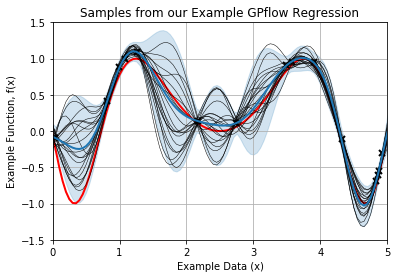

In [15]:
# create an array to store the samples in
num_s=20
samples=np.empty((len(xx),num_s),dtype='float')
# draw 20 samples
for s in range(num_s):
    samples[:,s] = m.predict_f_samples(xx, 1).squeeze()
# plot them
fig3=plt.figure()
plt.plot(xx,np.sin((xx[:, 0] - 2.5) ** 2).reshape(len(xx),1),'r',lw=2,label='Perfect f(x)')
plt.plot(xx,samples,'k',alpha=1,lw=0.5)
plt.plot(X, Y, 'kx', mew=2,label='Data')
line, = plt.plot(xx, mean, lw=2,label='$\mu$')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2,label='$2\sigma$')
plt.title('Samples from our Example GPflow Regression')
plt.ylabel('Example Function, f(x)')
plt.xlabel('Example Data (x)')
plt.ylim([-1.5,1.5])
plt.xlim([0,5])
plt.grid()
#plt.legend(loc='best')
plt.show()